In [1]:
a = [[0,1,0,1], [1,0,1,0], [0,1,0,1], [1,0,1,0], [0,1,0,1]]
a_flat = [b for sublist in a for b in sublist]
a_flat

[0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]

In [2]:
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
import numpy as np
import socket
from copy import deepcopy
import random
import struct
import pickle
import math
import subprocess
import re

In [3]:
def client_send(sock, arr):
    # packed_data = pickle.dumps(arr)
    packed_data = b''.join(x.to_bytes(32, byteorder='big') for x in arr)
    sock.sendall(packed_data)

def client_receive(sock, length):
    data = b''
    while len(data) < length:
        packet = sock.recv(length - len(data))
        if not packet:
            break
        data += packet
    # 将接收到的数据按每32字节一个长整型进行解析
    received_data = [int.from_bytes(data[i:i+32], byteorder='big') for i in range(0, len(data), 32)]
    return received_data

def client_send_one(sock, num):
    sock.sendall(str(num).encode())

def client_receive_one(sock, length):
    data = sock.recv(length)
    a = int(data)
    return a

In [4]:
def public_input_level(level, file_path): # for compute theta and gama
# 不用清除上一次执行痕迹，如果level符合起效就是合理的，如果level不符合也不会起效。
# 保持xor_theta与xor_theta_gama格式统一(为了代码复用我太难了)
    with open(file_path, 'r') as file:
        lines = file.readlines()
    print(lines)
    lines[0] = f"level = {level}\n"
    with open(file_path, 'w') as file:
        file.writelines(lines)

def public_input_theta(level, theta, beta, file_path): # for compute gama - fss_base
    with open(file_path, 'r') as file:
        lines = file.readlines()
    lines[0] = f"level = {level}\n"
    lines[2] = f"beta = {beta}\n"
    lines[3] = f"theta = {theta}\n"
    with open(file_path, 'w') as file:
        file.writelines(lines)

def public_input_beta(level, path, beta): # for trim tree - write only
    file_path = "./MP-SPDZ/Programs/Source/xor_theta_gama.mpc"
    with open(file_path, 'r') as file:
        lines = file.readlines()
    lines[3] = f"beta[{level}] = {beta}\n"
    with open(file_path, 'w') as file:
        file.writelines(lines)

def public_input_path(level, path, file_path): # for binary search - read only
    with open(file_path, 'r') as file:
        lines = file.readlines()
    lines[4] = f"path[{level}] = {path}\n"
    with open(file_path, 'w') as file:
        file.writelines(lines)

def mpc_xor_theta_tao_gama(Za_j, level, sock): # for fss_multi
    
    # file_path = "./MP-SPDZ/Programs/Source/xor_theta_gama.mpc"
    # public_input_level(level, file_path)
    
    # 定义要执行的 Bash 脚本命令
    commands = f'''
    cd ./MP-SPDZ
    ./compile.py xor_theta_gama
    echo {Za_j[0]} > Player-Data/Input-P0-0
    echo {Za_j[1]} >> Player-Data/Input-P0-0
    ./yao-party.x -OF theta_gama -p 0 xor_theta_gama
    '''
    # 执行命令并捕获输出
    process = subprocess.Popen(commands, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True, text=True)
    stdout, stderr = process.communicate()
    
    file_path = './MP-SPDZ/theta_gama-P0-0'

    with open(file_path, 'r') as file:
        lines = file.readlines()
    theta = int(lines[0].strip())
    tao0 = int(lines[1].strip())
    tao1 = int(lines[2].strip())
    gama = int(lines[3].strip())
    
    return theta, tao0, tao1, gama

def mpc_xor_gama(Za_j, level, theta, beta, sock): # fss_base
    
    # file_path = "./MP-SPDZ/Programs/Source/xor_gama.mpc"
    # public_input_theta(level, theta, beta, file_path)
    
    # 定义要执行的 Bash 脚本命令
    commands = f'''
    cd ./MP-SPDZ
    ./compile.py xor_gama
    echo {Za_j[0]} > Player-Data/Input-P0-0
    echo {Za_j[1]} >> Player-Data/Input-P0-0
    ./yao-party.x -OF gama -p 0 xor_gama
    '''
    # 执行命令并捕获输出
    process = subprocess.Popen(commands, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True, text=True)
    stdout, stderr = process.communicate()
    
    file_path = './MP-SPDZ/gama-P0-0'

    with open(file_path, 'r') as file:
        line1 = file.readline().strip()
    gama = int(line1)
    
    return gama

def mpc_xor_theta_tao(Za_j, level, sock): # fss_base
    
    # file_path = "./MP-SPDZ/Programs/Source/xor_theta.mpc"
    # public_input_level(level, file_path)
    
    # 定义要执行的 Bash 脚本命令
    commands = f'''
    cd ./MP-SPDZ
    ./compile.py xor_theta
    echo {Za_j[0]} > Player-Data/Input-P0-0
    echo {Za_j[1]} >> Player-Data/Input-P0-0
    ./yao-party.x -OF theta -p 0 xor_theta
    '''
    # 执行命令并捕获输出
    process = subprocess.Popen(commands, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True, text=True)
    stdout, stderr = process.communicate()
    
    file_path = './MP-SPDZ/theta-P0-0'

    with open(file_path, 'r') as file:
        lines = file.readlines()
    theta = int(lines[0].strip())
    tao0 = int(lines[1].strip())
    tao1 = int(lines[2].strip())
    
    return theta, tao0, tao1

def mpc_compare(level, sum, Sa_0, sock): # fss_base
    # 定义要执行的 Bash 脚本命令
    commands = f'''
    cd ./MP-SPDZ
    ./compile.py -B 256 compare
    echo {sum} > Player-Data/Input-P0-0
    echo {Sa_0} >> Player-Data/Input-P0-0
    ./yao-party.x -OF compare -p 0 compare
    '''
    # 执行命令并捕获输出
    process = subprocess.Popen(commands, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True, text=True)
    stdout, stderr = process.communicate()
    
    file_path = './MP-SPDZ/compare-P0-0'

    with open(file_path, 'r') as file:
        lines = file.readlines()
    equal = int(lines[0].strip())
    larger = int(lines[1].strip())
    
    # file_path = "./MP-SPDZ/Programs/Source/xor_theta_gama.mpc"
    # public_input_path(level+1, larger, file_path)
    
    return equal

In [5]:
def fss_read(arr, Ta):
    temp = 0
    for x, y in zip(arr, Ta):
        if y:
            temp = temp ^ x
    return temp

def fss_write(Ta, Ya, arr):
    # value_new = foq[level].writeStashValue.pop()
    # index, ifdown = foq[level].writeStashIndex.pop()
    # path = compute_path(foq, index)
    # value_ori = foq_read(level, ifdown, path, read_copy, Ta, foq)
    # value_deta = value_new ^ value_ori ^ beta # beta = random
    for t, y, w in zip(Ta, Ya, arr):#Ta[level], Ya[level], foq[level].up/down
        if t:
            w = y ^ w            
    return arr

In [6]:
#exchage XOR shares of array A
#path a[M]
#value beta

def Lsb(x):
    return x & 1

# M = 15

def fss_base(M, path, beta): # M = levelCount-1

    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    sock.connect(('127.0.0.1', 12345))
    '''
    a = [random.randint(1, 100) for _ in range(8)]
    mask = [random.randint(1, 100) for _ in range(8)]
    a_masked = [a[i] ^ mask[i] for i in range(8)]
    client_send(sock, mask)
    '''
    Sa_0 = get_random_bytes(16)
    # MPC
    Ta_0 = 0^(random.random() > 0.5)
    Tb_0 = 1^Ta_0
    client_send_one(sock, Tb_0)
    print('key changed')

    # 建立两个初始化为0的二维数组，各M+1行且第i行有2**i个元素
    Sa = [[0] *(2**i) for i in range(M+1)]
    Sa_ = deepcopy(Sa)
    Ta = deepcopy(Sa) # [[0] *(2**i) for i in range(M+1)]
    Tb = deepcopy(Sa) # [[0] *(2**i) for i in range(M+1)]
    theta = [0] * (M+1)
    tao = [[0] * (2) for i in range(M+1)]
    Za = deepcopy(tao) # [[0] * (2) for i in range(M+1)]
    Zb = deepcopy(tao) # [[0] * (2) for i in range(M+1)]
    Ya = [0] * (2**M)
    a = [0] + path[:M] 

    Sa[0][0] = int.from_bytes(Sa_0, byteorder='big')
    Sa_[0][0] = int.from_bytes(Sa_0, byteorder='big')
    #Ta[0][0] = int.from_bytes(Ta_0, byteorder='big')

    #Sa[0][0] = Sa_0
    Ta[0][0] = Ta_0

    key = b'\xd0\x16\x01\x0c,\xb0\xfa\xcd\xc6\xfdd\x11I$I('
    # ctr = Counter.new(128, initial_value=42)
    cipher = AES.new(key, AES.MODE_CTR, nonce=b'\xc7\xc9\n/\xf1\xf4\xe4\xcf')
    for j in range(1, M+1):   #range[1, M]
        for jx in range(0, 2**(j-1)):            
            plain = Sa_[j-1][jx].to_bytes((Sa_[j-1][jx].bit_length() + 7) // 8, byteorder='big')
            Sa[j][2*jx] = int.from_bytes(cipher.encrypt(plain), byteorder='big')
            Sa[j][2*jx+1] = int.from_bytes(cipher.encrypt(plain), byteorder='big')
            
            Za[j][0]= Za[j][0] ^ Sa[j][2*jx]
            Za[j][1]= Za[j][1] ^ Sa[j][2*jx+1]
        
        client_send(sock, Za[j])
        Zb[j]= client_receive(sock, 4096)

        #MPC
        theta[j] = Za[j][1^a[j]] ^ Zb[j][1^a[j]]
        tao[j][0] = Lsb(Za[j][0]) ^ Lsb(Zb[j][0]) ^ a[j] ^ 1
        tao[j][1] = Lsb(Za[j][1]) ^ Lsb(Zb[j][1]) ^ a[j]
        
        for jx in range(0, 2**j):
            temp = math.floor(jx/2)
            Sa_[j][jx] = Sa[j][jx]
            Ta[j][jx] = Lsb(Sa[j][jx])
            if Ta[j-1][temp]:
                Sa_[j][jx] ^= theta[j]
                Ta[j][jx] ^= tao[j][Lsb(jx)]
            
    #MPC        
    Ga = Za[M][a[j]] ^ Zb[M][a[j]] ^ theta[M] ^ beta

    sock.close()
    for jx in range(0, 2**M):
        Ya[jx] = Sa_[M][jx] 
        if Ta[M][jx]:
            Ya[jx] ^= Ga
        
        # fss_read(arr, Ta[j])
        # fss_write()
        # compare
        # mpc(如binary search) and change path
        
    return Ta, Ya

def fss_multi(M, path, beta): #beta有levelCount-1个元素

    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    sock.connect(('127.0.0.1', 12345))
    '''
    a = [random.randint(1, 100) for _ in range(8)]
    mask = [random.randint(1, 100) for _ in range(8)]
    a_masked = [a[i] ^ mask[i] for i in range(8)]
    client_send(sock, mask)
    '''
    Sa_0 = get_random_bytes(16)
    # MPC
    Ta_0 = 0^(random.random() > 0.5)
    Tb_0 = 1^Ta_0
    client_send_one(sock, Tb_0)
    print('key changed')

    # 建立两个初始化为0的二维数组，各M+1行且第i行有2**i个元素
    Sa = [[0] *(2**i) for i in range(M+1)]
    Sa_ = deepcopy(Sa)
    Ta = deepcopy(Sa) # [[0] *(2**i) for i in range(M+1)]
    Tb = deepcopy(Sa) # [[0] *(2**i) for i in range(M+1)]
    theta = [0] * (M+1)
    tao = [[0] * (2) for i in range(M+1)]
    Za = deepcopy(tao) # [[0] * (2) for i in range(M+1)]
    Zb = deepcopy(tao) # [[0] * (2) for i in range(M+1)]
    Ya = deepcopy(Sa)
    a = [0] + path[:M] 
    beta = [0] + beta[:M]
    Ga = [0]*(M+1)
    
    Sa[0][0] = int.from_bytes(Sa_0, byteorder='big')
    Sa_[0][0] = int.from_bytes(Sa_0, byteorder='big')
    #Ta[0][0] = int.from_bytes(Ta_0, byteorder='big')

    #Sa[0][0] = Sa_0
    Ta[0][0] = Ta_0

    key = b'\xd0\x16\x01\x0c,\xb0\xfa\xcd\xc6\xfdd\x11I$I('
    # ctr = Counter.new(128, initial_value=42)
    cipher = AES.new(key, AES.MODE_CTR, nonce=b'\xc7\xc9\n/\xf1\xf4\xe4\xcf')
    for j in range(1, M+1):   #range[1, M]
        for jx in range(0, 2**(j-1)):            
            plain = Sa_[j-1][jx].to_bytes((Sa_[j-1][jx].bit_length() + 7) // 8, byteorder='big')
            Sa[j][2*jx] = int.from_bytes(cipher.encrypt(plain), byteorder='big')
            Sa[j][2*jx+1] = int.from_bytes(cipher.encrypt(plain), byteorder='big')
            
            Za[j][0]= Za[j][0] ^ Sa[j][2*jx]
            Za[j][1]= Za[j][1] ^ Sa[j][2*jx+1]
        
        client_send(sock, Za[j])
        Zb[j]= client_receive(sock, 4096)

        #MPC
        theta[j] = Za[j][1^a[j]] ^ Zb[j][1^a[j]]
        tao[j][0] = Lsb(Za[j][0]) ^ Lsb(Zb[j][0]) ^ a[j] ^ 1
        tao[j][1] = Lsb(Za[j][1]) ^ Lsb(Zb[j][1]) ^ a[j]
        
        for jx in range(0, 2**j):
            temp = math.floor(jx/2)
            Sa_[j][jx] = Sa[j][jx]
            Ta[j][jx] = Lsb(Sa[j][jx])
            if Ta[j-1][temp]:
                Sa_[j][jx] ^= theta[j]
                Ta[j][jx] ^= tao[j][Lsb(jx)]
            
        #MPC        
        Ga[j] = Za[j][a[j]] ^ Zb[j][a[j]] ^ theta[j] ^ beta[j]

        sock.close()
        for jx in range(0, 2**j):
            Ya[j][jx] = Sa_[j][jx] 
            if Ta[j][jx]:
                Ya[j][jx] ^= Ga[j]
        
        # fss_read(arr, Ta[j])
        # fss_write()
        # compare
        # mpc(如binary search) and change path
        
    return Ta, Ya

In [7]:
'''
M = 5
path = [0, 0, 1, 0, 1]
beta = 24538
fss_base(M, path, beta)
'''

'\nM = 5\npath = [0, 0, 1, 0, 1]\nbeta = 24538\nfss_base(M, path, beta)\n'

In [8]:
def AES_key_exchange():
    import socket
    from cryptography.hazmat.primitives.asymmetric import dh
    from cryptography.hazmat.primitives.serialization import Encoding, PublicFormat, ParameterFormat
    from cryptography.hazmat.primitives import serialization
    from cryptography.hazmat.backends import default_backend
    from cryptography.hazmat.primitives.kdf.hkdf import HKDF
    from cryptography.hazmat.primitives import hashes

    # 创建Socket并连接到服务器
    client_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    client_socket.connect(('localhost', 65432))

    # 接收DH参数
    parameters_bytes = client_socket.recv(4096)
    parameters = serialization.load_pem_parameters(parameters_bytes, backend=default_backend())

    # 接收服务器的公钥
    server_public_key_bytes = client_socket.recv(4096)
    server_public_key = serialization.load_pem_public_key(server_public_key_bytes, backend=default_backend())

    # 生成私钥
    private_key = parameters.generate_private_key()

    # 生成公钥
    public_key = private_key.public_key()

    # 将公钥序列化以便交换
    public_key_bytes = public_key.public_bytes(Encoding.PEM, PublicFormat.SubjectPublicKeyInfo)

    # 发送公钥给服务器
    client_socket.sendall(public_key_bytes)

    # 生成共享密钥
    shared_key = private_key.exchange(server_public_key)

    # 使用HKDF对共享密钥进行派生，得到对称密钥
    derived_key = HKDF(
        algorithm=hashes.SHA256(),
        length=16,  # 设置为16字节
        salt=None,
        info=b'handshake data',
        backend=default_backend()
    ).derive(shared_key)

    print("Derived Symmetric Key (Client):", derived_key)

    # 关闭连接
    client_socket.close()

    return derived_key

In [9]:
def extract_fractions_elements(arr, level):
    n = len(arr)
    for j in range(1, level + 1):
        fractions = [k / 2**j for k in range(1, 2**j, 2)]
        elements = [arr[int(f * n)] for f in fractions]
    return elements

In [10]:
def Lsb(x):
    return x & 1

def fss_base(Sa_0, key, M, option): # , path, deta # M = levelCount-1
    cipher = AES.new(key, AES.MODE_CTR, nonce=key[-8:])
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    sock.connect(('127.0.0.1', 12347))
    '''
    mask = server_receive(client_socket, 1024)
    '''
    # MPC
    Ta_0 = 0^(random.random() > 0.5)
    Tb_0 = 1^Ta_0
    client_send_one(sock, Tb_0)
    print('key changed')

    # 建立两个初始化为0的二维数组，各M+1行且第i行有2**i个元素
    Sa = [[0] *(2**i) for i in range(M+1)]
    Sa_ = deepcopy(Sa)
    Ta = deepcopy(Sa) 
    Tb = deepcopy(Sa) 
    theta = [0] * (M+1)
    tao = [[0] * (2) for i in range(M+1)]
    Za = deepcopy(tao) 
    Zb = deepcopy(tao) 
    Ya = [0] * (2**M)
    # a = [0] + path[:M]

    Sa[0][0] = int.from_bytes(Sa_0, byteorder='big')
    Sa_[0][0] = int.from_bytes(Sa_0, byteorder='big')
    #Sa[0][0] = Sa_0
    Ta[0][0] = Ta_0
    #Ta[0][0] = int.from_bytes(Ta_0, byteorder='big')
    # key = b'\xd0\x16\x01\x0c,\xb0\xfa\xcd\xc6\xfdd\x11I$I('
    # ctr = Counter.new(128, initial_value=42)
    # cipher = AES.new(key, AES.MODE_CTR, nonce=b'\xc7\xc9\n/\xf1\xf4\xe4\xcf')
    for j in range(1, M+1):   #range[1, M]
        
        for jx in range(0, 2**(j-1)):            
            plaintext = Sa_[j-1][jx].to_bytes((Sa_[j-1][jx].bit_length() + 7) // 8, byteorder='big')
            Sa[j][2*jx] = int.from_bytes(cipher.encrypt(plaintext), byteorder='big')
            Sa[j][2*jx+1] = int.from_bytes(cipher.encrypt(plaintext), byteorder='big')
            Za[j][0]= Za[j][0] ^ Sa[j][2*jx]
            Za[j][1]= Za[j][1] ^ Sa[j][2*jx+1]
        
        # Zb[j] = server_receive(client_socket, 4096)
        # server_send(client_socket, Za[j])

        #MPC
        # theta[j] = Za[j][1^a[j]] ^ Zb[j][1^a[j]]
        # tao[j][0] = Lsb(Za[j][0]) ^ Lsb(Zb[j][0]) ^ a[j] ^ 1
        # tao[j][1] = Lsb(Za[j][1]) ^ Lsb(Zb[j][1]) ^ a[j]
        
        theta[j], tao[j][0], tao[j][1] = mpc_xor_theta_tao(Za[j], j, sock)
        tao[j][0] = Lsb(tao[j][0])
        tao[j][1] = Lsb(tao[j][1])
        
        for jx in range(0, 2**j):
            temp = math.floor(jx/2)
            Sa_[j][jx] = Sa[j][jx]
            Ta[j][jx] = Lsb(Sa[j][jx])
            if Ta[j-1][temp]:
                Sa_[j][jx] ^= theta[j]
                Ta[j][jx] ^= tao[j][Lsb(jx)]

    #MPC
    # Ga = Za[M][a[M]] ^ Zb[M][a[M]] ^ theta[M] ^ beta
    
    Ga = mpc_xor_gama(Za[M], M, theta[M], sock)
    
    for jx in range(0, 2**M):
        Ya[jx] = Sa_[M][jx]
        if Ta[M][jx]:
            Ya[jx] ^= Ga
            
    sock.close()

    return Ta, Ya

def fss_multi(Sa_0, key, M, write_arr, read_arr, option, t): # , path, deta #beta有levelCount-1个元素
    cipher = AES.new(key, AES.MODE_CTR, nonce=key[-8:])
    
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    sock.connect(('127.0.0.1', 12347+t))
    '''
    mask = server_receive(client_socket, 1024)
    '''
    # MPC
    Ta_0 = 0^(random.random() > 0.5)
    Tb_0 = 1^Ta_0
    client_send_one(sock, Tb_0)
    print('key changed')

    # 建立两个初始化为0的二维数组，各M+1行且第i行有2**i个元素
    Sa = [[0] *(2**i) for i in range(M+1)]
    Sa_ = deepcopy(Sa)
    Ta = deepcopy(Sa)
    Tb = deepcopy(Sa)
    theta = [0] * (M+1)
    tao = [[0] * (2) for i in range(M+1)]
    Za = deepcopy(tao) 
    Zb = deepcopy(tao) 
    Ya = deepcopy(Sa)
    Ga = [0]*(M+1)
    # a = [0] + path[:M] 
    # beta = [0] + deta[:M]
    equal = 0 # 找到就为1，也可以不使用该关键字
    
    Sa[0][0] = int.from_bytes(Sa_0, byteorder='big')
    Sa_[0][0] = int.from_bytes(Sa_0, byteorder='big')
    #Sa[0][0] = Sa_0
    Ta[0][0] = Ta_0
    #Ta[0][0] = int.from_bytes(Ta_0, byteorder='big')
    
    # ctr = Counter.new(128, initial_value=42)
    
    for j in range(1, M+1):   #range[1, M]

        for jx in range(0, 2**(j-1)):            
            plaintext = Sa_[j-1][jx].to_bytes((Sa_[j-1][jx].bit_length() + 7) // 8, byteorder='big')
            Sa[j][2*jx] = int.from_bytes(cipher.encrypt(plaintext), byteorder='big')
            Sa[j][2*jx+1] = int.from_bytes(cipher.encrypt(plaintext), byteorder='big')
            Za[j][0]= Za[j][0] ^ Sa[j][2*jx]
            Za[j][1]= Za[j][1] ^ Sa[j][2*jx+1]
        
        # Zb[j] = server_receive(client_socket, 4096)
        # server_send(client_socket, Za[j])
        
        # MPC
        # theta[j] = Za[j][1^a[j]] ^ Zb[j][1^a[j]]
        # Ga[j] = Za[j][a[j]] ^ Zb[j][a[j]] ^ theta[j] ^ beta[j]
        
        if option == 'binary_search':
            arr_j = extract_fractions_elements(read_arr, j)
            sum = fss_read(arr_j, Ta[j])
            mpc_compare(j, sum, Sa[0][0], sock)
            
        theta[j], tao[j][0], tao[j][1], Ga[j] = mpc_xor_theta_tao_gama(Za[j], j, sock)
        tao[j][0] = Lsb(tao[j][0])
        tao[j][1] = Lsb(tao[j][1])
        
        for jx in range(0, 2**j):
            temp = math.floor(jx/2)
            Sa_[j][jx] = Sa[j][jx]
            Ta[j][jx] = Lsb(Sa[j][jx])
            if Ta[j-1][temp]:
                Sa_[j][jx] ^= theta[j]
                Ta[j][jx] ^= tao[j][Lsb(jx)]

        for jx in range(0, 2**j):
            Ya[j][jx] = Sa_[j][jx]
            if Ta[j][jx]:
                Ya[j][jx] ^= Ga[j]
        
        if option == 'trim tree': 
            mpc_compare(j, sum, Sa[0][0], sock)
            # 假设server0是执行查询的一方（没有client的情况）
            # public_input_beta(j+1, beta)
            arr = fss_write(Ta[j], Ya[j], write_arr)
        
    sock.close()

    return Ta, Ya

In [11]:
# key = AES_key_exchange()
key = b'7\xed\xa7v\x03\xec\xfe\x9d\xac\xa7\xef\x86=c\xbe\x1a'
Sa_0 = get_random_bytes(16)

In [12]:
sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
sock.connect(('127.0.0.1', 12345))
mask = client_receive(sock, (2**15) * 32)
sock.close()

In [13]:
Sa = int.from_bytes(Sa_0, byteorder='big')
arr_mine = []
for j in mask:
    arr_mine.append(Sa ^ j)

In [14]:
sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
sock.connect(('127.0.0.1', 12346))

client_send(sock, arr_mine)
arr_other = client_receive(sock, (2**15) * 32)

sock.close()

In [15]:
arr = []
for i, j in zip(arr_mine, arr_other):
    arr.append(i ^ j)

In [16]:
# for t in range(0, 32):

M = 
Ta, Ya = fss_multi(Sa_0, key, M, mask, arr, 'binary_search', 0)

key changed


In [ ]:
sock.close()

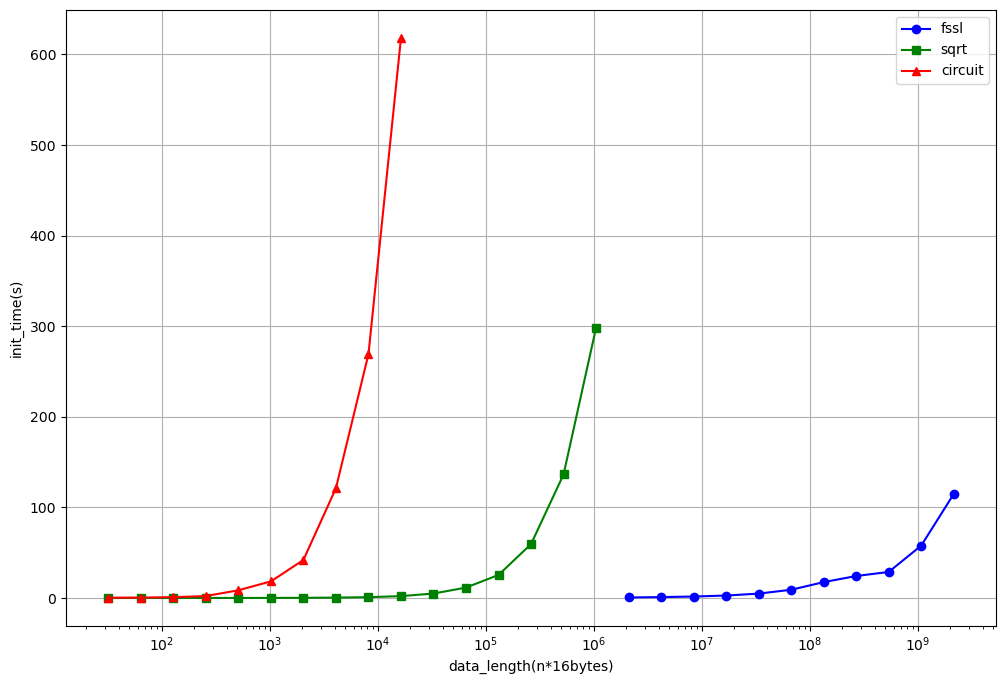

In [ ]:
import matplotlib.pyplot as plt

# Define the data extracted from the provided outputs
e_values_fssl = [2097152, 4194304, 8388608, 16777216, 33554432, 67108864, 
                134217728, 268435456, 536870912, 1073741824, 2147483648]
total_times_fssl = [17.433480, 29.040074, 48.357166, 80.900581, 144.971354, 272.280226, 
                    525.476470, 728.208006, 862.258871, 1736.113097, 3446.298360]
i_value_fssl = 30
y_values_fssl = [time / i_value_fssl for time in total_times_fssl]

e_values_sqrt = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576]
total_times_sqrt = [0.095612, 0.134845, 0.226878, 0.449705, 0.960860, 2.379766, 5.384620, 12.098964, 27.472889, 61.565317, 146.957096, 34.480936, 76.347899, 178.438054, 409.171469, 895.076715]
i_values_sqrt = [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3, 3, 3, 3, 3]
y_values_sqrt = [time / i for time, i in zip(total_times_sqrt, i_values_sqrt)]

e_values_circuit = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
total_times_circuit = [2.669051, 4.534178, 9.046162, 21.132117, 85.279144, 183.297704, 419.650282, 1211.967943, 2691.188611, 618.223501]
i_values_circuit = [10, 10, 10, 10, 10, 10, 10, 10, 10, 1]
y_values_circuit = [time / i for time, i in zip(total_times_circuit, i_values_circuit)]

# Create the combined plot
plt.figure(figsize=(12, 8))

# Plot each dataset with a different color and label
plt.plot(e_values_fssl, y_values_fssl, marker='o', linestyle='-', color='b', label='fssl')
plt.plot(e_values_sqrt, y_values_sqrt, marker='s', linestyle='-', color='g', label='sqrt')
plt.plot(e_values_circuit, y_values_circuit, marker='^', linestyle='-', color='r', label='circuit')

# Set the labels
plt.xlabel('data_length(n*16bytes)')
plt.ylabel('init_time(s)')

# Set the scale of x-axis to logarithmic
plt.xscale('log')

# Add a legend to distinguish the lines
plt.legend()

# Show the plot with grid
plt.grid(True)
plt.show()


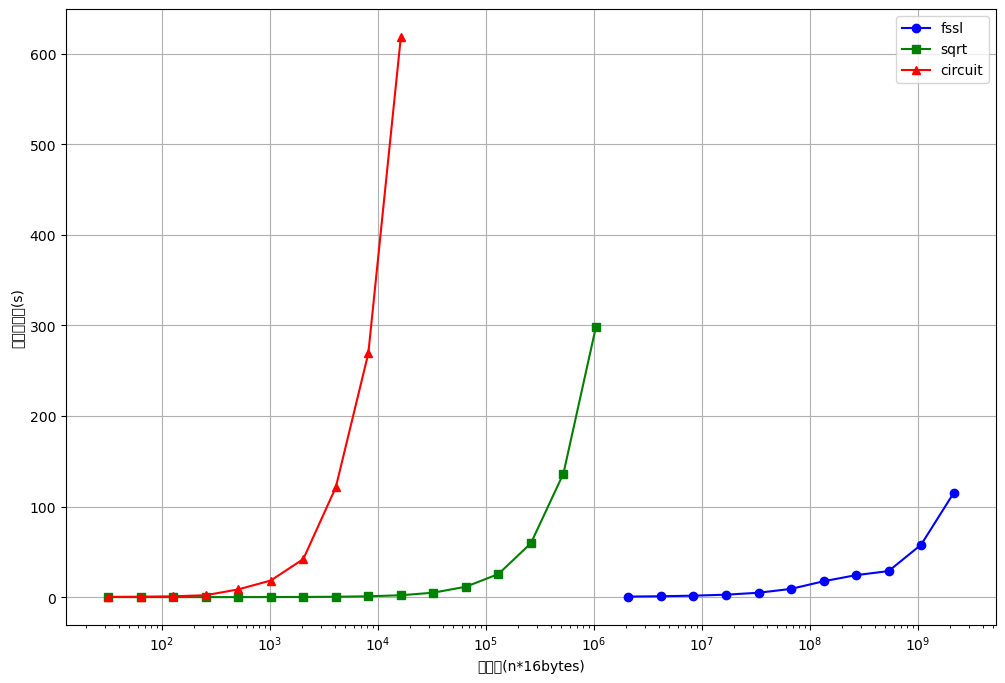

In [ ]:
# Combine the data for all three plots
e_values_combined = e_values_fssl + e_values_sqrt + e_values_circuit
y_values_combined = y_values_fssl + y_values_sqrt + y_values_circuit
labels_combined = (['fssl'] * len(e_values_fssl)) + (['sqrt'] * len(e_values_sqrt)) + (['circuit'] * len(e_values_circuit))

# Create the combined plot
plt.figure(figsize=(12, 8))

# Plot each dataset with a different color and label
plt.plot(e_values_fssl, y_values_fssl, marker='o', linestyle='-', color='b', label='fssl')
plt.plot(e_values_sqrt, y_values_sqrt, marker='s', linestyle='-', color='g', label='sqrt')
plt.plot(e_values_circuit, y_values_circuit, marker='^', linestyle='-', color='r', label='circuit')

# Set the labels
plt.xlabel('数据量(n*16bytes)')
plt.ylabel('初始化时间(s)')

# Set the scale of x-axis to logarithmic
plt.xscale('log')

# Add a legend to distinguish the lines
plt.legend()

# Show the plot with grid
plt.grid(True)
plt.show()


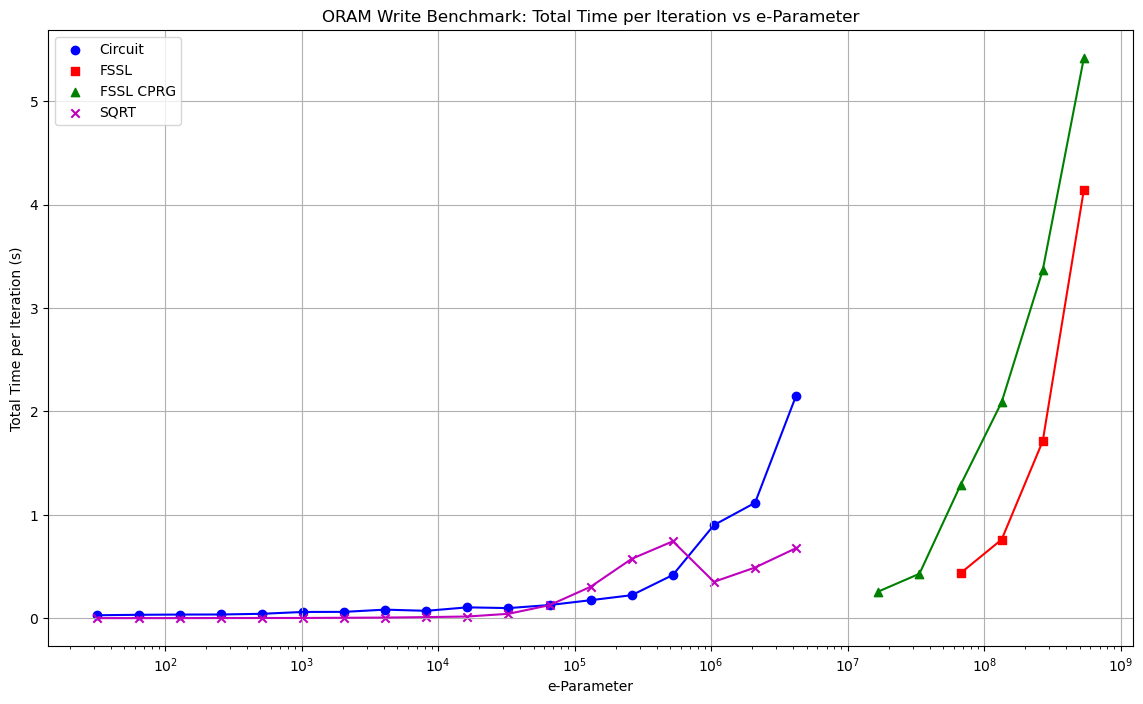

In [ ]:
import matplotlib.pyplot as plt
# Define all the data sets for combined plot

# Circuit data
e_values_write_circuit = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304]
total_times_write_circuit = [0.288619, 0.332754, 0.354991, 0.361814, 0.428824, 0.607619, 0.615181, 0.832264, 0.716905, 1.052830, 0.981190, 1.274927, 1.744865, 2.229261, 4.182622, 9.012088, 11.163756, 21.535561]
i_values_write_circuit = [10] * len(e_values_write_circuit)
y_values_write_circuit = [time / i for time, i in zip(total_times_write_circuit, i_values_write_circuit)]

# FSSL data
e_values_write_fssl = [67108864, 134217728, 268435456, 536870912]
total_times_write_fssl = [17.438702, 42.614972, 137.032889, 468.171357]
i_values_write_fssl = [40, 56, 80, 113]
y_values_write_fssl = [time / i for time, i in zip(total_times_write_fssl, i_values_write_fssl)]

# FSSL CPRG data
e_values_write_fssl_cprg = [16777216, 33554432, 67108864, 134217728, 268435456, 536870912]
total_times_write_fssl_cprg = [2.583608, 3.011233, 25.774548, 29.260103, 67.340593, 151.694288]
i_values_write_fssl_cprg = [10, 7, 20, 14, 20, 28]
y_values_write_fssl_cprg = [time / i for time, i in zip(total_times_write_fssl_cprg, i_values_write_fssl_cprg)]

# SQRT data
e_values_write_sqrt = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304]
total_times_write_sqrt = [0.112409, 0.123801, 0.148293, 0.246210, 0.312703, 0.505898, 0.651184, 1.383362, 3.405218, 7.724992, 29.009525, 125.612073, 441.464384, 1214.719650, 2287.527104, 1572.495744, 3178.242574, 6366.697716]
i_values_write_sqrt = [104, 114, 116, 132, 132, 196, 145, 214, 315, 463, 679, 993, 1450, 2113, 3074, 4465, 6478, 9387]
y_values_write_sqrt = [time / i for time, i in zip(total_times_write_sqrt, i_values_write_sqrt)]

# Create the combined plot
plt.figure(figsize=(14, 8))

# Plot each data set
plt.scatter(e_values_write_circuit, y_values_write_circuit, color='b', label='Circuit', marker='o')
plt.plot(e_values_write_circuit, y_values_write_circuit, linestyle='-', color='b')

plt.scatter(e_values_write_fssl, y_values_write_fssl, color='r', label='FSSL', marker='s')
plt.plot(e_values_write_fssl, y_values_write_fssl, linestyle='-', color='r')

plt.scatter(e_values_write_fssl_cprg, y_values_write_fssl_cprg, color='g', label='FSSL CPRG', marker='^')
plt.plot(e_values_write_fssl_cprg, y_values_write_fssl_cprg, linestyle='-', color='g')

plt.scatter(e_values_write_sqrt, y_values_write_sqrt, color='m', label='SQRT', marker='x')
plt.plot(e_values_write_sqrt, y_values_write_sqrt, linestyle='-', color='m')

# Set the title and labels
plt.title('ORAM Write Benchmark: Total Time per Iteration vs e-Parameter')
plt.xlabel('e-Parameter')
plt.ylabel('Total Time per Iteration (s)')

# Set the scale of x-axis to logarithmic
plt.xscale('log')

# Show legend
plt.legend()

# Show the plot with grid
plt.grid(True)
plt.show()
